# Donkey Car Model

My attempts to build a CNN from scratch are hitting walls. I am going to try out a model suggested on the [Donkey Car Webpage](https://docs.donkeycar.com/dev_guide/model/), to establish a "baseline" (very broadly) of sorts to which I can compate the "custom" models of my own design.

Steps:
1. Establish modeling parameters
1. Split data into training and testing sets
1. Scale telemetry data with scikitlearn's minmaxscaler or standardscaler
1. Save the scaler to scale fresh driving input data for inferences
1. Define methods to construct, fit, plot, and save a model
1. Fit, save, and plot a constructed model with a range of batch sizes
1. Save the model and record path and metrics/parameters in a CSV file

In [1]:
## Imports
import numpy as np
import pandas as pd
import time
import pickle
import sklearn.metrics as metrics
from os.path import exists

from modeling_methods import run_model, plot_metrics, save_model, create_donkey_vimu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2021-11-23 05:53:13.281773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [26]:
## Directories
working_date = '11_12_2021'
working_time = '19_28_18'

## Directories
data_directory = f'../data/{working_date}/{working_time}'
model_directory = f'../models/{working_date}/{working_time}'

## File paths
cam_input_dataset_file = f'{data_directory}/X_img.npy'
telem_input_dataset_file = f'{data_directory}/X_telem.pkl'
target_dataset_file = f'{data_directory}/y.npy'

## Parameters
scaler = 'minmax' # ['minmax', 'standard']
dual_outputs = True
batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]
early_stop_patience = 5 # None for no stop
epochs = 250

create_model = create_donkey_vimu

## Data

### Load Datasets

In [27]:
## Load the datasets
X_cam = np.load(cam_input_dataset_file)
X_telem = pd.read_pickle(telem_input_dataset_file).to_numpy()
y = np.load(target_dataset_file)

## Split for dual output
if dual_outputs:
    y_steering = y[:, 0]
    y_throttle = y[:, 1]

## Check Shape
X_cam.shape

(115052, 64, 64, 1)

### Train-Test Split

In [28]:
if dual_outputs:
    datasets = train_test_split(X_cam, X_telem, y_steering, y_throttle, test_size=0.1, random_state=0)
else:
    datasets = train_test_split(X_cam, X_telem, y, test_size=0.1, random_state=0)
    
X_cam_train = datasets[0]
X_cam_test = datasets[1]
X_telem_train = datasets[2]
X_telem_test = datasets[3]
y_train = datasets[4]
y_test = datasets[5]
    
if dual_outputs:
    y_st_train = datasets[4]
    y_st_test = datasets[5]
    y_th_train = datasets[6]
    y_th_test = datasets[7]

### Scale IMU Data

In [29]:
sc = None
scaler_file = None
if scaler == 'minmax':
    sc = MinMaxScaler() # default range: [0, 1]
    scaler_file = f'{data_directory}/scalers/mm_scaler_{time.strftime("%m_%d_%H_%M")}.pkl'
elif scaler == 'standard':
    sc = StandardScaler()
    scaler_file = f'{data_directory}/scalers/ss_scaler_{time.strftime("%m_%d_%H_%M")}.pkl'

## Fit to then and transform training data
X_telem_train_sc = sc.fit_transform(X_telem_train)
## Transform testing data
X_telem_test_sc = sc.transform(X_telem_test)

### Save the Scaler for Predictions

In [30]:
## Save as pickle
pickle.dump(sc, open(scaler_file, 'wb'))

## Print path
scaler_file

'../data/11_12_2021/19_28_18/mm_scaler_11_19_02_56.pkl'

### Get Input Shape(s)

In [31]:
## Create variables
cam_input_shape = X_cam_train[0].shape
telem_input_shape = X_telem_train_sc[0].shape

## Check telemetry input shape
telem_input_shape

(4,)

## Model Loop

---
Batch size 16 start: 02:56:37
Batch size 16 end:   03:08:10
Epochs run: 29
path: ../models/11_12_2021/19_28_18/model_183.h5
---
Batch size 32 start: 03:08:10
Batch size 32 end:   03:15:53
Epochs run: 36
path: ../models/11_12_2021/19_28_18/model_184.h5
---
Batch size 64 start: 03:15:53
Batch size 64 end:   03:20:04
Epochs run: 29
path: ../models/11_12_2021/19_28_18/model_185.h5
---
Batch size 128 start: 03:20:04
Batch size 128 end:   03:23:22
Epochs run: 29
path: ../models/11_12_2021/19_28_18/model_186.h5
---
Batch size 256 start: 03:23:22
Batch size 256 end:   03:28:01
Epochs run: 48
path: ../models/11_12_2021/19_28_18/model_187.h5
---
Batch size 512 start: 03:28:01
Batch size 512 end:   03:32:10
Epochs run: 46
path: ../models/11_12_2021/19_28_18/model_188.h5
---
Batch size 1024 start: 03:32:10
Batch size 1024 end:   03:38:06
Epochs run: 69
path: ../models/11_12_2021/19_28_18/model_189.h5
---
Batch size 2048 start: 03:38:06
Batch size 2048 end:   03:47:01
Epochs run: 106
path: ../m

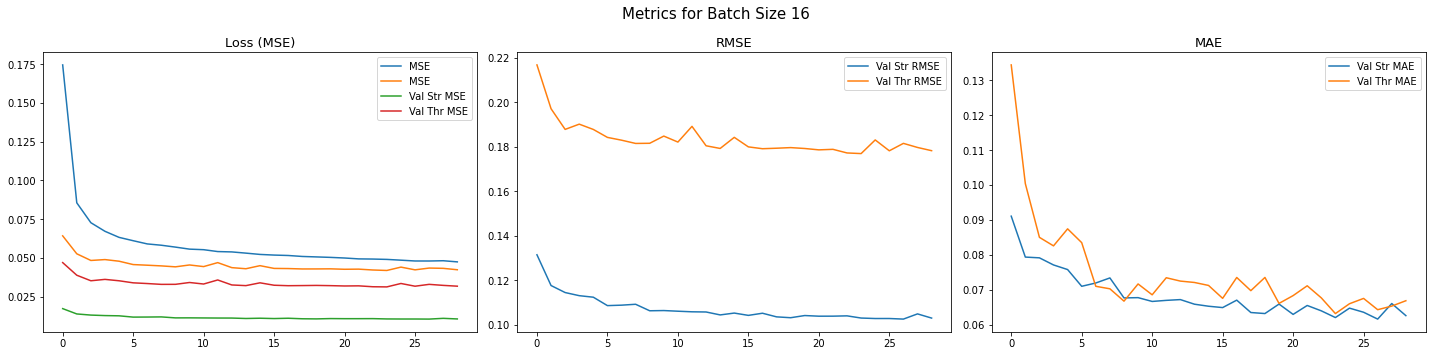

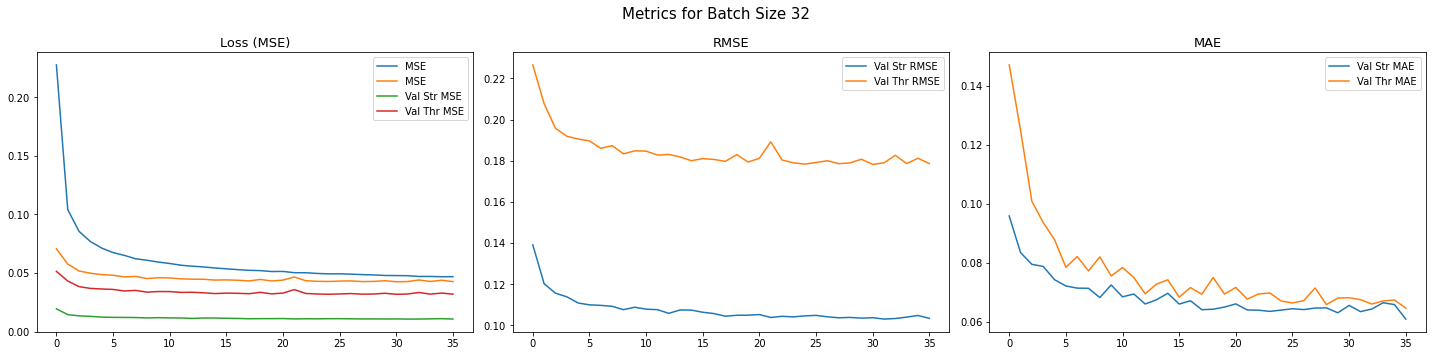

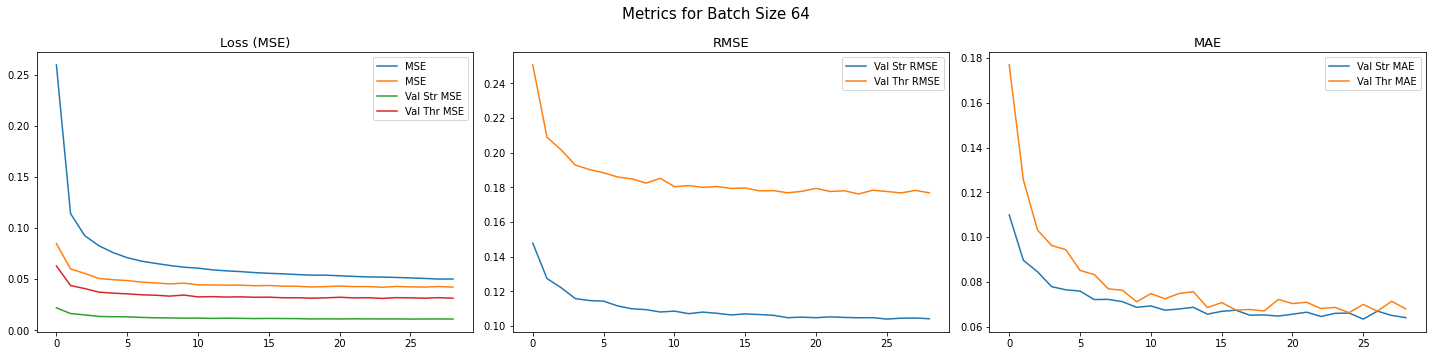

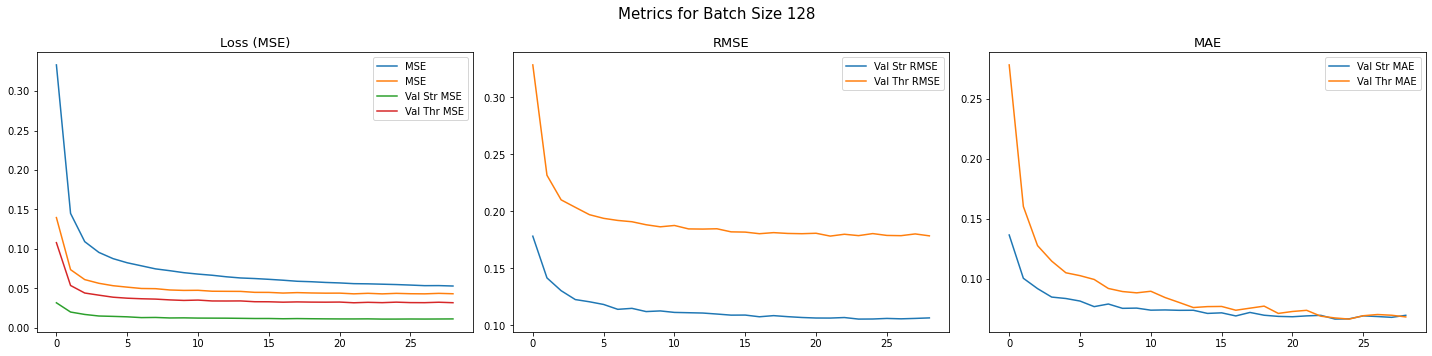

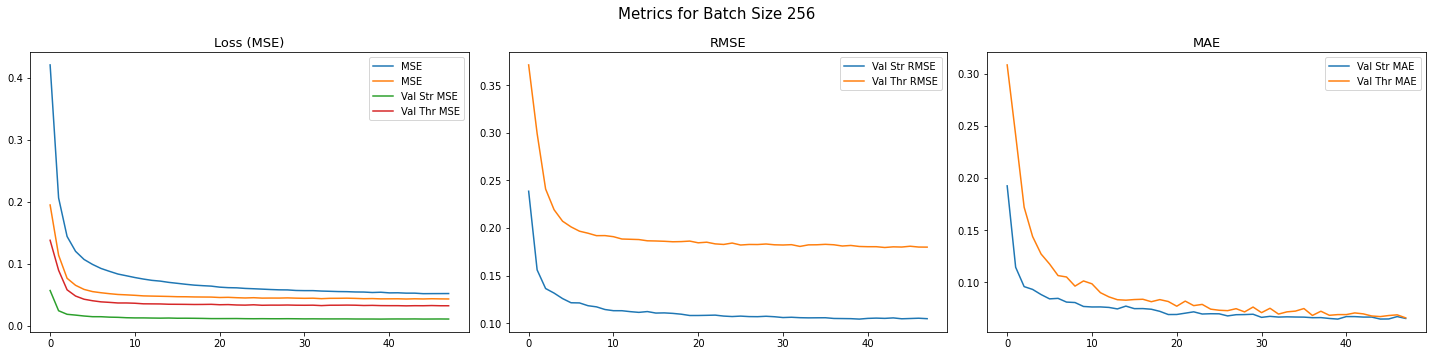

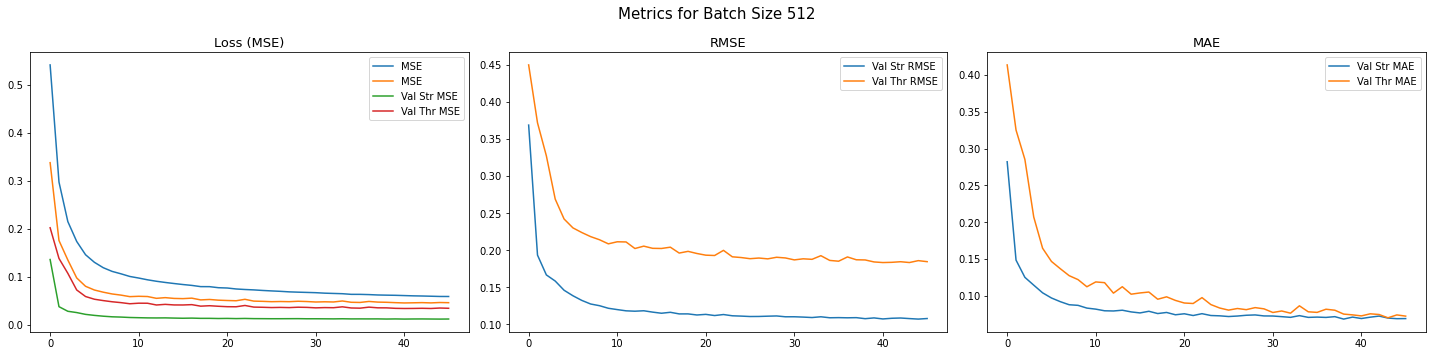

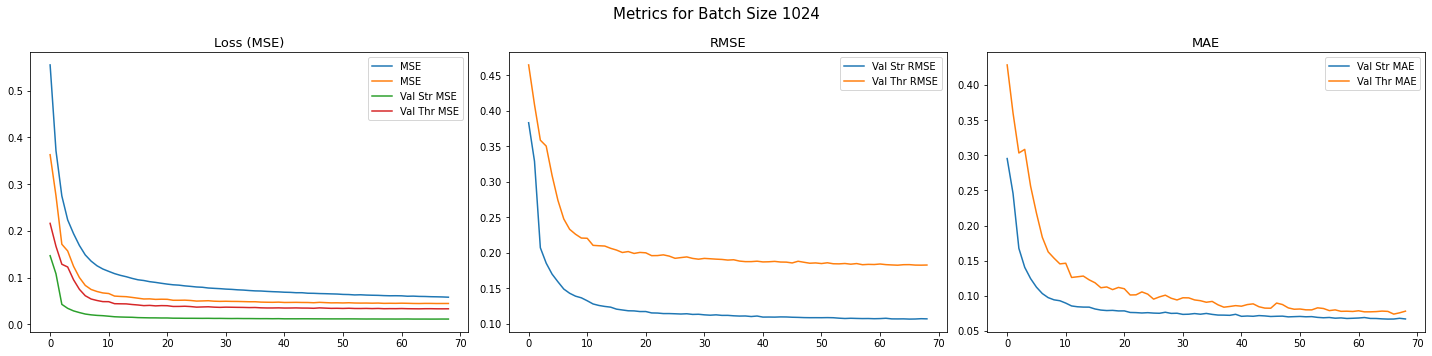

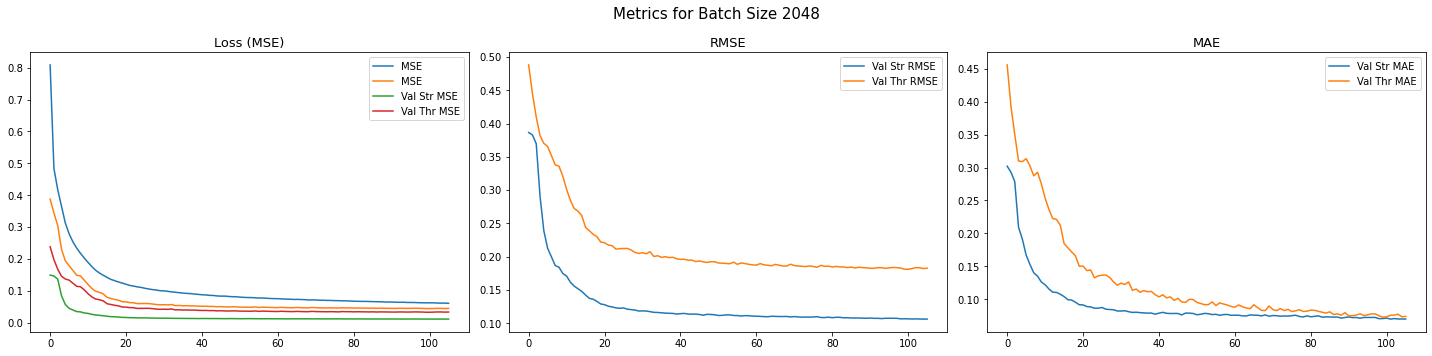

In [32]:
X_train = [X_cam_train, X_telem_train_sc]
X_test = (X_cam_test, X_telem_test_sc)

if dual_outputs:
    y_train = (y_st_train, y_th_train)
    y_test = (y_st_test, y_th_test)
else:
    y_train = y_train
    y_test = y_test

## Run models for each batch size
print('---')
for batch_size in batch_sizes:
    print(f'Batch size {batch_size} start: {time.strftime("%H:%M:%S")}')
    model = create_model(cam_input_shape, telem_input_shape, dual_outputs)
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=['mae', RootMeanSquaredError()])
    model, results = run_model(model, X_train, y_train, X_test, y_test, 
                               batch_size, epochs,
                              early_stop_patience=early_stop_patience)
    model_path = save_model(model_directory, model, results, batch_size, 
                            dual_outputs, scaler_file)
    history = {k: v for k, v in results.history.items()}
    plot_metrics(history, batch_size, dual_outputs)
    print(f'Batch size {batch_size} end:   {time.strftime("%H:%M:%S")}')
    print(f'Epochs run: {len(history["loss"])}')
    print(f'path: {model_path}')
    print('---')
# model_history.tail(len(batch_sizes))